# Example of how to use cira with scikit-learn 

understand that this is just an example and not a good model for actual trading.

In this example we will setup cira and use Liner Regression as an model and try to make prediction on a crypto asset. 

### Cira setup

In [1]:
import cira

In [2]:
cira.auth.KEY_FILE = "../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [3]:
#portfolio = cira.Portfolio()
exchange = cira.Exchange()

### Fetching data 

In [4]:
from datetime import datetime

SYMBOL = "SPY"

cry = cira.Stock(SYMBOL)    

start = datetime(2020, 7, 1)
end = datetime(2023, 7, 1)

data = cry.historical_data_df(start_date=start, end_date=end)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2020-07-01 04:00:00+00:00,SPY,309.54,311.89,309.07,310.57,72474858.0,418495.0,310.486119
2020-07-02 04:00:00+00:00,SPY,314.24,315.70,311.51,312.19,69344217.0,433527.0,313.315661
2020-07-06 04:00:00+00:00,SPY,316.37,317.68,315.56,317.01,61713828.0,331248.0,316.169274
2020-07-07 04:00:00+00:00,SPY,315.38,317.52,313.37,313.77,82909978.0,398769.0,315.437016
2020-07-08 04:00:00+00:00,SPY,314.61,316.30,312.70,316.16,54638669.0,325899.0,314.892715


### Machine learning

training the model 

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


y = data[['close']]
X = data[['open', 'high', 'low']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 3.6098473671662688


using the models predictions

In [6]:
def trade_stocks(predictions, threshold=0.0):
    """ Buy if 1 sell -1 """
    BUY = 1 
    SELL = -1
    HOLD = 0
    positions = [BUY if pred > threshold else SELL for pred in predictions]
    positions = [HOLD if positions[i] == positions[i-1] else positions[i] for i in range(len(positions)) ]
    for i, position in enumerate(positions): 
        if position == BUY:
            break 
        if position == SELL:
            positions[i] = HOLD
    return positions

In [7]:
positions = trade_stocks(y_pred, threshold=400)
print(positions)

[0, 0, 0, 0, 0, 0, 1, 0, -1, 0, 1, 0, 0, -1, 1, 0, -1, 0, 1, -1, 0, 0, 0, 0, 1, 0, -1, 0, 1, 0, -1, 0, 1, -1, 0, 0, 1, 0, 0, 0, -1, 0, 1, -1, 0, 0, 1, 0, -1, 0, 0, 1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 1, -1, 0, 1, -1, 1, -1, 1, -1, 0, 1, 0, -1, 1, 0]


## New model 

In [8]:
from datetime import datetime
import pandas as pd

SYMBOL = "SPY"

stk = cira.Stock(SYMBOL)    

start = datetime(2018, 7, 1)
end = datetime(2023, 7, 1)

data = stk.historical_data_df(start_date=start, end_date=end)
print(data.head(2))
print(len(data))



                          symbol    open    high     low   close      volume  \
timestamp                                                                      
2018-07-02 04:00:00+00:00    SPY  269.51  272.04  269.24  271.84  63769156.0   
2018-07-03 04:00:00+00:00    SPY  272.87  272.98  270.42  270.88  42201071.0   

                           trade_count        vwap  
timestamp                                           
2018-07-02 04:00:00+00:00     279127.0  270.689557  
2018-07-03 04:00:00+00:00     180591.0  271.716151  
1258


In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Split the data into a training set and a test set
train_data = data[:int(len(data)*0.8)]
test_data =  data[int(len(data)*0.8):]

# Create the features and target
features = train_data[["open", "high", "low"]]
target = train_data["close"]

# Train the model
model = LinearRegression()
model.fit(features, target)

predictions = model.predict(test_data[["open", "high", "low"]])



In [39]:
import pandas as pd
import numpy as np
from typing import List

fees = lambda price, qty: .004 * price * qty
buy_and_hold = lambda data_ser, initial_capital: data_ser * initial_capital - data_ser[0]*initial_capital

def back_test(model, data_set:pd.Series, x_features_names:List[str], y_name:str, capital=100_000.0, threshold = 0.01, use_fees:bool = True):
    _portfolio = {
        "capital":[],
        "timestamp":[]
    }  
    stk_q = 0  
    for i, s in enumerate(data_set[y_name]):
        if len(data_set) == i+1: break
        y_pred = model.predict(data_set[x_features_names][:1+i])
        close_price = data_set[y_name][1+i] 
        for i in range(len(y_pred)):
            diff = y_pred[-1] - data_set[y_name][i]
            if diff > threshold: # Buy
                capital -= close_price - fees(close_price, 1) * use_fees
                stk_q += 1 
            elif diff < -threshold and stk_q > 0: # Sell
                capital += close_price - fees(close_price, 1) * use_fees
                stk_q -= 1 
            else: # Hold 
                pass
        _portfolio["capital"].append(capital + stk_q*close_price)
        _portfolio["timestamp"].append(data_set.index[i])

    df = pd.DataFrame(_portfolio)
    df = df.set_index("timestamp")
    df.index = pd.to_datetime(df.index.get_level_values('timestamp'))
    return df
        




best threshold 0.09999999999999999
model: 579159.4621199826$
Buy and hold profit: 530500.0000000005$
diff: 1.0917237740244714


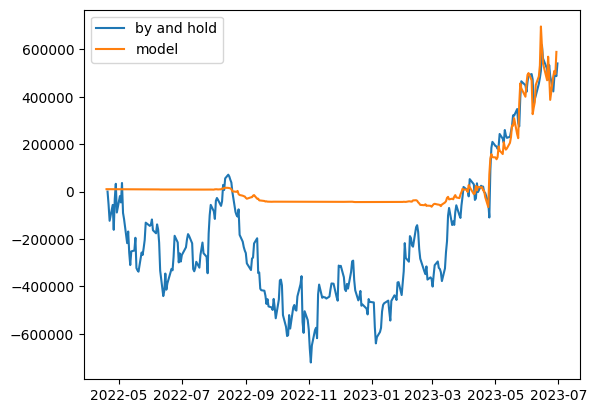

In [40]:
INITIAL_CAPITAL = 10_000.0
bh = buy_and_hold(test_data["close"][1:], INITIAL_CAPITAL) 


max_res = -INITIAL_CAPITAL
best_pref = 0
for th in [0.01 + 0.01*i for i in range(10)]:
    res = back_test(model, test_data, ["open", "high", "low"], "close", threshold=th, capital=INITIAL_CAPITAL)
    pref = res["capital"][-1] 
    if pref > max_res:
        max_res = pref
        best_pref = th


res = back_test(model, test_data, ["open", "high", "low"], "close", threshold=best_pref, capital=INITIAL_CAPITAL)
print("best threshold", best_pref)

bh_prof = bh[-1] - INITIAL_CAPITAL
model_prof = res['capital'][-1] - INITIAL_CAPITAL
print(f"model: {model_prof}$")
print(f"Buy and hold profit: {bh_prof}$")
print(f"diff: {model_prof / bh_prof}")


plt.plot(bh, label="by and hold")
plt.plot(res, label="model")
plt.legend()
plt.show()

### Momentum 

In [12]:
from datetime import datetime
import pandas as pd

SYMBOL = "TSLA"

stk = cira.Stock(SYMBOL)    

start = datetime(2022, 7, 1)
end = datetime(2023, 7, 1)

data = stk.historical_data_df(start_date=start, end_date=end)
print(data.head(2))
print(len(data))

                          symbol   open    high       low   close      volume  \
timestamp                                                                       
2022-07-01 04:00:00+00:00   TSLA  681.0  690.69  666.3601  681.79  24817437.0   
2022-07-05 04:00:00+00:00   TSLA  669.0  699.44  648.5001  699.20  28259653.0   

                           trade_count        vwap  
timestamp                                           
2022-07-01 04:00:00+00:00     624843.0  676.780771  
2022-07-05 04:00:00+00:00     783236.0  674.624637  
251


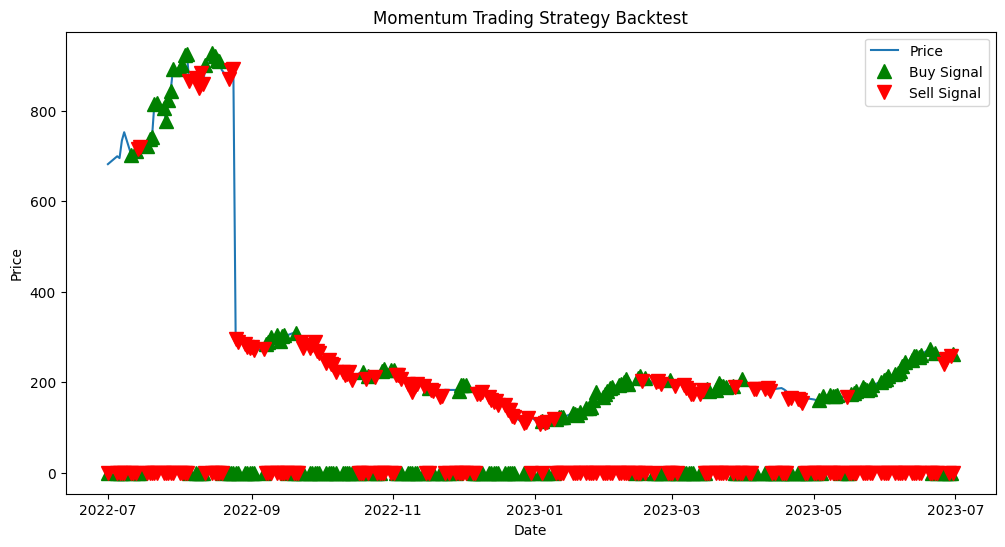

Final Capital: 193364.94571300855


In [13]:
import pandas as pd

# Load your data
# Assuming 'df' is your DataFrame with the given data
df = data.copy()
# Step 1: Calculate Returns
df['returns'] = df['close'].pct_change()

# Step 2: Calculate Momentum
N = 5  # Choose an appropriate value for N
df['momentum'] = df['close'].pct_change(periods=N)

# Step 3: Generate Buy and Sell Signals
# For example, you can use a simple condition like if momentum > 0.02, then buy, else if momentum < -0.02, then sell
buy_condition = df['momentum'] > 0.02
sell_condition = df['momentum'] < -0.02

df['buy_signal'] = buy_condition.astype(int)
df['sell_signal'] = sell_condition.astype(int)

# Step 4: Backtesting
initial_capital = 100000
capital = initial_capital
position = 0

for i, row in df.iterrows():
    if row['buy_signal'] == 1 and position == 0:
        position = capital / row['close']
        capital -= position * row['close']
    elif row['sell_signal'] == 1 and position > 0:
        capital += position * row['close']
        position = 0

# Calculate final capital
final_capital = capital + (position * df['close'].iloc[-1])

# Create a new column to mark buy and sell points
df['buy_marker'] = df['buy_signal'] * df['close']
df['sell_marker'] = df['sell_signal'] * df['close']

# Plotting
plt.figure(figsize=(12,6))
plt.plot(df.index, df['close'], label='Price')
plt.plot(df.index, df['buy_marker'], 'g^', label='Buy Signal', markersize=10)
plt.plot(df.index, df['sell_marker'], 'rv', label='Sell Signal', markersize=10)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Momentum Trading Strategy Backtest')
plt.legend()
plt.show()

print(f"Final Capital: {final_capital}")

